In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import random

In [2]:
def feature_detection(img1, img2):
    my_SIFT_instance = cv2.SIFT_create()
    kp1, desc1 = my_SIFT_instance.detectAndCompute(img1, None) # returns list of keypoints and an array of 128xkp
    kp2, desc2 = my_SIFT_instance.detectAndCompute(img2, None) # setting mask field to None
    img_1 = cv2.drawKeypoints(img1, kp1, img1)
    img_2 = cv2.drawKeypoints(img2, kp2, img2)
    bf_matcher = cv2.BFMatcher()  # returns the best match
    matches = bf_matcher.knnMatch(desc1, desc2, k=2)  # returns the k best matches
   
    # Using Lowe's Ratio Test to evaluate if the euclidean distance of one match is less than distance to next best match using threshold of 0.8
    good_match = []
    good_no_list = []
    for m, n in matches:
        if m.distance < 0.8*n.distance: # using each matches euclidean distance
            good_match.append([m]) # only considering the best matches
            good_no_list.append(m)

    pl = np.float32([kp1[i.queryIdx].pt for i in good_no_list]) # queryIdx = This attribute gives us the index of the descriptor in the list of img1 descriptors
    pr = np.float32([kp2[i.trainIdx].pt for i in good_no_list]) # trainIdx = This attribute gives us the index of the descriptor in the list of img2 descriptors
    
    kp_L = []
    kp_R = []
    for j in range(len(pl)):
        kp_L.append(cv2.KeyPoint(pl[j][0], pl[j][1], 2))
        kp_R.append(cv2.KeyPoint(pr[j][0], pr[j][1], 2))
    
    return kp_L, kp_R, pl, pr

Text(0.5, 1.0, 'Right KeyPoints')

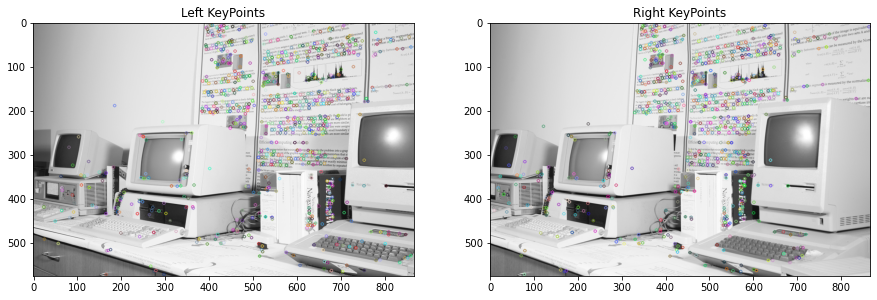

In [3]:
comp_L = cv2.cvtColor(cv2.imread("computers_left.png"), cv2.COLOR_BGR2GRAY)
comp_R= cv2.cvtColor(cv2.imread("computers_right.png"), cv2.COLOR_BGR2GRAY)
comp_L_cpy = comp_L.copy()
comp_R_cpy = comp_R.copy()

kp_L, kp_R, pl, pr = feature_detection(comp_L_cpy, comp_R_cpy)

fig = plt.figure(figsize=(15, 10))
rows = 1
columns = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(cv2.drawKeypoints(comp_L_cpy, kp_L, comp_L_cpy))
plt.title("Left KeyPoints")

fig.add_subplot(rows, columns, 2)
plt.imshow(cv2.drawKeypoints(comp_R_cpy, kp_R, comp_R_cpy))
plt.title("Right KeyPoints")

In [4]:
def draw_epipolar_lines(img, lines, pt):
    height, width, _ = img.shape
    for i in range(len(lines)):
        colour  = [random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)]
        l_bound = [0, int(-lines[i][2] / lines[i][1])] # if x = 0 --> Y = -C/B
        r_bound = [width, int(-(lines[i][2] + lines[i][0]*width) / lines[i][1])] # if x = width --> y = (-C - A*width)/B
        img = cv2.line(img, (l_bound[0], l_bound[1]), (r_bound[0], r_bound[1]), colour , 1)
        img = cv2.circle(img, tuple(pt[i][0]), 4, colour, -1)
    return img

In [5]:
comp_L = cv2.imread("computers_left.png")
comp_L_cpy = comp_L.copy()
comp_L_cpy_gray = cv2.cvtColor(comp_L_cpy, cv2.COLOR_BGR2GRAY)
comp_R= cv2.imread("computers_right.png")
comp_R_cpy = comp_R.copy()
comp_R_cpy_gray = cv2.cvtColor(comp_R_cpy, cv2.COLOR_BGR2GRAY)

kp_L, kp_R, pl, pr = feature_detection(comp_L_cpy_gray, comp_R_cpy_gray)

pl_int = np.int32(pl)
pr_int = np.int32(pr)

F, M = cv2.findFundamentalMat(pl_int, pr_int, cv2.FM_LMEDS)
pl_int = pl_int[M.ravel()==1].reshape(-1, 1, 2) # ravel used to turn multidimensional arrays into linear arrays
pr_int = pr_int[M.ravel()==1].reshape(-1, 1, 2)

L_lines = cv2.computeCorrespondEpilines(pr_int, 2, F).reshape(-1,3) # points, which image, input arry
imgl = draw_epipolar_lines(comp_L_cpy, L_lines, pl_int)

R_lines = cv2.computeCorrespondEpilines(pl_int, 1, F).reshape(-1,3)
imgr = draw_epipolar_lines(comp_R_cpy, R_lines, pr_int)

fig = plt.figure(figsize=(15, 10))
rows = 1
columns = 2

np_hor = np.hstack((imgl, imgr))

while True:
    cv2.imshow("Full Output", np_hor )
    if cv2.waitKey(1) == 27: # if user hits ESC key --> window is exited
            break 
cv2.destroyAllWindows()

<Figure size 1080x720 with 0 Axes>

In [6]:
daft_L = cv2.imread("daft_punk_left.jpg")
daft_L_cpy = daft_L.copy()
daft_L_cpy_gray = cv2.cvtColor(daft_L_cpy, cv2.COLOR_BGR2GRAY)
daft_R = cv2.imread("daft_punk_right.jpg")
daft_R_cpy = daft_R.copy()
daft_R_cpy_gray = cv2.cvtColor(daft_R_cpy, cv2.COLOR_BGR2GRAY)


kp_L, kp_R, pl, pr = feature_detection(daft_L_cpy_gray, daft_R_cpy_gray)

pl_int = np.int32(pl)
pr_int = np.int32(pr)
F, M = cv2.findFundamentalMat(pl_int, pr_int, cv2.FM_LMEDS)
pl_int = pl_int[M.ravel()==1].reshape(-1, 1, 2) # ravel used to turn multidimensional arrays into linear arrays
pr_int = pr_int[M.ravel()==1].reshape(-1, 1, 2)
L_lines = cv2.computeCorrespondEpilines(pr_int, 2, F).reshape(-1,3) # points, which image, input arry
imgl_1 = draw_epipolar_lines(daft_L_cpy, L_lines, pl_int)

R_lines = cv2.computeCorrespondEpilines(pl_int, 1, F).reshape(-1,3)
imgr_1 = draw_epipolar_lines(daft_R_cpy, R_lines, pr_int)

fig = plt.figure(figsize=(15, 10))
rows = 1
columns = 2
np_hor_2 = np.hstack((imgl_1, imgr_1))

while True:
    cv2.imshow("Full Output - DAFT", np_hor_2 )
    if cv2.waitKey(1) == 27: # if user hits ESC key --> window is exited
            break 
cv2.destroyAllWindows()

<Figure size 1080x720 with 0 Axes>

In [7]:
daft_L = cv2.imread("daft_punk_left.jpg")
daft_L_cpy2 = daft_L.copy()
daft_L_cpy_gray = cv2.cvtColor(daft_L_cpy, cv2.COLOR_BGR2GRAY)
daft_R = cv2.imread("daft_punk_right.jpg")
daft_R_cpy2 = daft_R.copy()
daft_R_cpy_gray = cv2.cvtColor(daft_R_cpy, cv2.COLOR_BGR2GRAY)

kp_L, kp_R, pl, pr = feature_detection(daft_L_cpy_gray, daft_R_cpy_gray)
pl_int = np.int32(pl)
pr_int = np.int32(pr)
F, M = cv2.findFundamentalMat(pl_int, pr_int, cv2.FM_LMEDS)

def point_to_epipolar_line(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        daft_L_cpy2, daft_R_cpy2, F = param
        left_point = (x, y)
        height, width, _ = daft_R_cpy2.shape
        daft_L_cpy2 = cv2.circle(daft_L_cpy2, left_point, 4, [random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)], -1)
        left_point = np.int32(left_point).reshape(-1, 1, 2)
        R_line = cv2.computeCorrespondEpilines(left_point, 1, F).reshape(3)
        Rl_line = np.int32(R_line)
        x0, y0 = [0, int(-R_line[2] / R_line[1])]
        xb, yb = [width, int(-(R_line[2] + R_line[0] * width) / R_line[1])]
        daft_R_cpy2 = cv2.line(daft_R_cpy2, (x0, y0), (xb, yb), [255, 0, 0], 1)

cv2.namedWindow("POINT/CONJUGATE EPIPOLAR LINE SELECTION", cv2.WINDOW_FULLSCREEN)
cv2.setMouseCallback("POINT/CONJUGATE EPIPOLAR LINE SELECTION", point_to_epipolar_line, (daft_L_cpy2, daft_R_cpy2, F))
while True:
    np_hor = np.hstack((daft_L_cpy2, daft_R_cpy2))
    cv2.imshow("POINT/CONJUGATE EPIPOLAR LINE SELECTION", np.hstack((daft_L_cpy2, daft_R_cpy2)))
    if cv2.waitKey(1) == 27:
            break 
cv2.destroyAllWindows()

In [8]:
comp_L = cv2.imread("computers_left.png")
comp_L_cpy2 = comp_L.copy()
comp_L_cpy_gray = cv2.cvtColor(comp_L_cpy, cv2.COLOR_BGR2GRAY)
comp_R = cv2.imread("computers_right.png")
comp_R_cpy2 = comp_R.copy()
comp_R_cpy_gray = cv2.cvtColor(comp_R_cpy, cv2.COLOR_BGR2GRAY)

kp_L, kp_R, pl, pr = feature_detection(comp_L_cpy_gray, comp_R_cpy_gray)

pl_int = np.int32(pl)
pr_int = np.int32(pr)

F, M = cv2.findFundamentalMat(pl_int, pr_int, cv2.FM_LMEDS)
pl_int = pl_int[M.ravel()==1].reshape(-1, 1, 2) # ravel used to turn multidimensional arrays into linear arrays
pr_int = pr_int[M.ravel()==1].reshape(-1, 1, 2)

def point_to_epipolar_line(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        comp_L_cpy2, comp_R_cpy2, F = param
        left_point = (x, y)
        height, width, _ = comp_R_cpy2.shape
        comp_L_cpy2 = cv2.circle(comp_L_cpy2, left_point, 5, [random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)], -1)
        left_point = np.int32(left_point).reshape(-1, 1, 2)
        R_line = cv2.computeCorrespondEpilines(left_point, 1, F).reshape(3)
        Rl_line = np.int32(R_line)
        x0, y0 = [0, int(-R_line[2] / R_line[1])]
        xb, yb = [width, int(-(R_line[2] + R_line[0] * width) / R_line[1])]
        comp_R_cpy2 = cv2.line(comp_R_cpy2, (x0, y0), (xb, yb), [255, 0, 0], 1)

cv2.namedWindow("POINT/CONJUGATE EPIPOLAR LINE SELECTION", cv2.WINDOW_FULLSCREEN)
cv2.setMouseCallback("POINT/CONJUGATE EPIPOLAR LINE SELECTION", point_to_epipolar_line, (comp_L_cpy2, comp_R_cpy2, F))
while True:
    np_hor = np.hstack((comp_L_cpy2, comp_R_cpy2))
    cv2.imshow("POINT/CONJUGATE EPIPOLAR LINE SELECTION", np.hstack((comp_L_cpy2, comp_R_cpy2)))
    if cv2.waitKey(1) == 27:
            break 
cv2.destroyAllWindows()